In [134]:
import numpy as np

import torch

import matplotlib.pyplot as plt

In [135]:
# taken from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

## Data

torchvision CIFAR10 dataset's images have pixel values between [0,1], we'll transform them 
to [-1,1] so that it's symmetric.

In [147]:
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize

transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)


def make_dataloaders(batch_size=32):
    train_ds, val_ds = random_split(ds, [45000, 5000] ,generator=torch.Generator().manual_seed(42))
    train_dl = DataLoader(train_ds, batch_size=batch_size,  num_workers=2)
    val_dl = DataLoader(val_ds, batch_size=batch_size,  num_workers=2)
    return train_dl, val_dl


Files already downloaded and verified
Files already downloaded and verified


In [148]:
# partly taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

CLASSES = ds.classes

def show_sample(img, y):
    img = img / 2 + 0.5     # unnormalize
    plt.title(CLASSES[y])
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)).squeeze())
    plt.show()

Let's inspect a few data points.

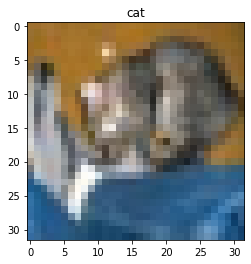

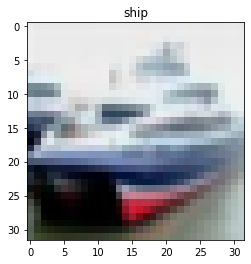

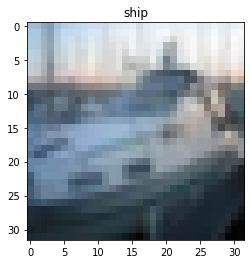

In [149]:
images, labels = iter(test_dl).next()
for i in range(3):
    show_sample(images[i], labels[i])

## Model Architecture

We'll compare a simple convolutional neural network and a ResNet.

#### Our simple convolutional neural network

In [150]:
# taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
          nn.Conv2d(3, 16, 3),
          nn.MaxPool2d(2, 2),
          nn.ReLU(),
          nn.Conv2d(16, 32, 3),
          nn.MaxPool2d(2, 2),
          nn.ReLU(),
          nn.Conv2d(32, 64, 3),
          nn.MaxPool2d(2, 2),
          nn.Flatten(),
          nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)


#### ResNet

In [151]:
# taken from https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py

import torch.nn as nn
import torch.nn.functional as F

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


## Train

In [152]:
def evaluate(model, dl):
    model.eval()
    loss_fn = torch.nn.CrossEntropyLoss()
    true_predictions = 0
    false_predictions = 0
    for images, labels in dl:
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            loss = loss_fn(logits, labels)
        class_predictions = torch.argmax(logits, axis=-1)
        true_predictions_batch  = torch.sum(class_predictions == labels)
        false_predictions_batch = torch.sum(class_predictions != labels)
        true_predictions  += true_predictions_batch.item()
        false_predictions += false_predictions_batch.item()
    
    accuracy = true_predictions / (true_predictions + false_predictions)
    return loss, accuracy

def train(model, optimizer, train_dl, val_dl, n_epoch=1, every_n_batch=0, early_stop_after=3, early_stop_tolerance=1e-3):
    model.cuda()
    loss_fn = torch.nn.CrossEntropyLoss()

    train_loss_list = [] 
    val_loss_list = []

    early_stop_counter = 0
    lowest_loss = float('inf')
    i = 0
    while early_stop_counter < early_stop_after and i < n_epoch:
        i += 1
        print('-'*32)
        print(f'epoch {i}')
        print('-'*32)
        model.train()
        for j, (train_images, train_labels) in enumerate(train_dl):
            if every_n_batch and j and j % every_n_batch == 0:
                batch_ds = TensorDataset(torch.unsqueeze(train_images, dim=0), torch.unsqueeze(train_labels, dim=0))
                batch_score = evaluate(model, batch_ds)
                print(f'batch {j} - accuracy: {batch_score:.4f}')
            train_images, train_labels = train_images.cuda(), train_labels.cuda()
            class_scores = model(train_images)
            loss = loss_fn(class_scores, train_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss.item())
        
        train_loss, train_score = evaluate(model, train_dl)
        val_loss, val_score = evaluate(model, val_dl)
        if len(val_loss_list) and (lowest_loss - val_loss) < early_stop_tolerance:
            early_stop_counter += 1
        else:
            early_stop_counter = 0
        val_loss_list.append(val_loss)
        lowest_loss = min(val_loss, lowest_loss)

        print(f'train loss: {train_loss:.8f} | validation loss: {val_loss:.8f}')
        print(f'train accuracy: {train_score:.4f} | validation accuracy: {val_score:.4f}')
        print('-'*32)

    if early_stop_counter >= early_stop_after:
        print("EARLY STOPPED!")
    
    return model, train_loss_list, val_loss_list, val_score

def run_experiment(model, lr, bs, optim_cls, **kwargs):
    optimizer = optim_cls(model.parameters(), lr=lr)
    train_dl, val_dl = make_dataloaders(bs)
    model, train_losses, val_losses, val_score = train(model, optimizer, train_dl, val_dl,  **kwargs)
    return model, train_losses, val_losses, val_score

In [153]:
import itertools

def run_all_experiments(model_fns, lr_space, bs_space, optimizer_space, **kwargs):
    experiment_results = []
    for i, (model_fn, lr, bs, optim_cls) in enumerate(itertools.product(model_fns, lr_space, bs_space, optimizer_space)):
        print("==========================================")
        print(f"Experiment {i+1}")
        print("==========================================")
        print(f"model {i}")
        print(f"learning rate = {lr}")
        print(f"batch size = {bs}")
        print(f"optimizer = {optim_cls.__name__}")
        model, train_loss_list, val_loss_list, val_score = run_experiment(model_fn(), lr, bs, optim_cls, **kwargs)
        experiment_results.append(
            (dict(model_idx=i,lr=lr,bs=bs,optim_cls=optim_cls), 
             dict(model=model, train_loss_list=train_loss_list, val_loss_list=val_loss_list, score=val_score))
        )
        print("==========================================")
    
    return experiment_results

### Experiments

In [154]:
# Helper for plotting the loss graph smoothly. 
def smoothen_losses(loss_list):
    filter_size = 10
    moving_average_filter = [1/filter_size] * filter_size
    return np.convolve(loss_list, moving_average_filter, 'valid') 

def plot_loss_graph(train_losses, val_losses):
    train_losse = smoothen_losses(train_losses)

    fig = plt.figure(figsize=(12, 8))
    plt.plot(train_losses, label='train')
    n_iter = len(train_losses)
    n_epoch = len(val_losses)
    x = (np.arange(n_epoch) * n_iter / n_epoch).astype('int')
    plt.plot(x, val_losses, label='validation')

    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend()
    return fig    


In [156]:
experiment_results = run_all_experiments(
    model_fns = [Net, lambda : ResNet(ResidualBlock, [2, 2, 2])],
    lr_space = [1e-4],
    bs_space=[64], 
    optimizer_space = [torch.optim.Adam],
    n_epoch=50,
)


Experiment 1
model 0
learning rate = 0.0001
batch size = 64
optimizer = Adam
--------------------------------
epoch 1
--------------------------------
train loss: 1.46885026 | validation loss: 1.46944451
train accuracy: 0.3469 | validation accuracy: 0.3404
--------------------------------
--------------------------------
epoch 2
--------------------------------
train loss: 1.07124746 | validation loss: 1.26115370
train accuracy: 0.4080 | validation accuracy: 0.4116
--------------------------------
--------------------------------
epoch 3
--------------------------------
train loss: 0.93469167 | validation loss: 1.23524284
train accuracy: 0.4385 | validation accuracy: 0.4350
--------------------------------
--------------------------------
epoch 4
--------------------------------
train loss: 0.87293035 | validation loss: 1.21524858
train accuracy: 0.4580 | validation accuracy: 0.4476
--------------------------------
--------------------------------
epoch 5
------------------------------

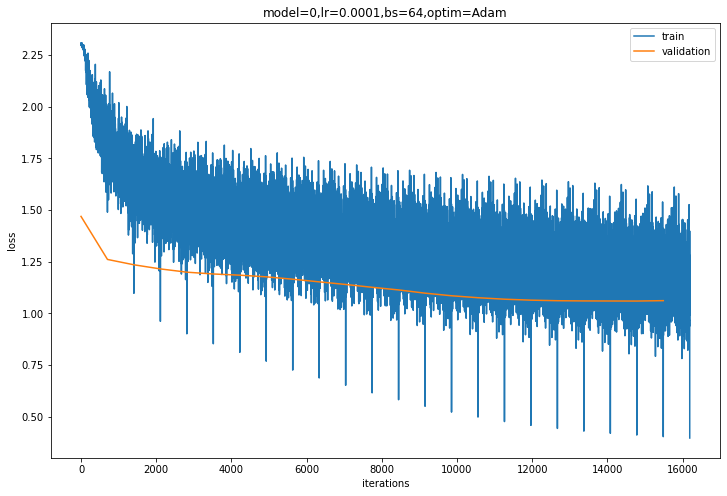

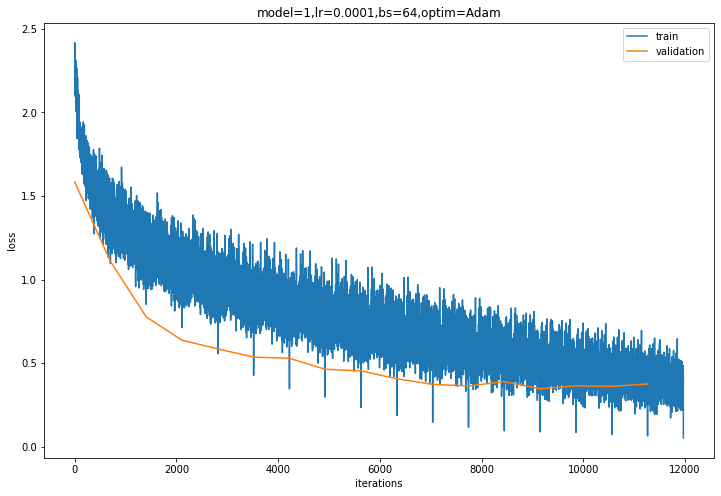

In [159]:
def make_label(model_idx, lr, bs, optim_cls):
    return f"model={model_idx},lr={lr},bs={bs},optim={optim_cls.__name__}"

for inp, output in experiment_results:
    fig = plot_loss_graph(
        output['train_loss_list'], 
        output['val_loss_list']
    )
    plt.title(make_label(**inp))

## Evaluation

In [165]:
train_dl, val_dl = make_dataloaders(128)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2)

def report_scores(model):
    train_loss, train_score = evaluate(model, train_dl)
    print(f'train accuracy: {train_score:.3f}')

    val_loss, val_score = evaluate(model, val_dl)
    print(f'validation accuracy: {val_score:.3f}')

    test_loss, test_score = evaluate(model, test_dl)
    print(f'test accuracy: {test_score:.3f}')


Let's evaluate the performance of our simple CNN model and ResNet.

In [166]:
simple_cnn = experiment_results[0][1]['model']
print("Our simple CNN")
print("="*32)
report_scores(simple_cnn)

Our simple CNN
train accuracy: 0.599
validation accuracy: 0.571
test accuracy: 0.570


In [167]:
best_experiment = max(experiment_results, key=lambda res: res[1]['score'])
best_model = best_experiment[1]['model']
print("ResNet")
print("="*32)
report_scores(best_model)

ResNet
train accuracy: 0.831
validation accuracy: 0.684
test accuracy: 0.681


## Save & Load

Let's save our model, load it back and evaluate its performance.

In [170]:
torch.save(simple_cnn, 'model.pth')
loaded_model = torch.load('model.pth')
print("Loaded CNN")
print("="*32)
report_scores(loaded_model)

Loaded CNN
train accuracy: 0.599
validation accuracy: 0.571
test accuracy: 0.570
